# Давайте на примере рассмотрим, как можно построить систему рекомендаций на основе популярности.

Мы будем работать с набором данных Movie Lens. Он содержит идентификаторы для каждого фильма и пользователя, который его смотрел, а также оценку, которую пользователь поставил фильму. В датасете представлено 25 000 095 оценок фильмов от 162 541 пользователя со шкалой оценок от 0.5 до 5.0.

In [2]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
# sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

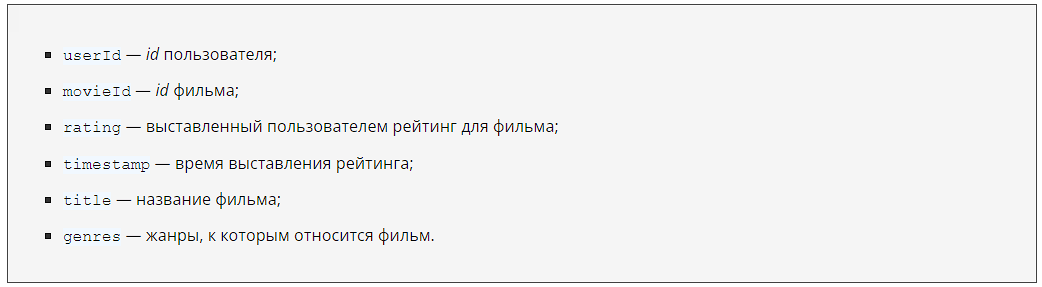

In [4]:
movies = pd.read_csv('data/movie.zip')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [11]:
ratings = pd.read_csv('data/dst-3.0_mathml_14_5_rating.zip')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [14]:
ratings

userId  movieId  rating            timestamp
0              1        2     3.5  2005-04-02 23:53:47
1              1       29     3.5  2005-04-02 23:31:16
2              1       32     3.5  2005-04-02 23:33:39
3              1       47     3.5  2005-04-02 23:32:07
4              1       50     3.5  2005-04-02 23:29:40
...          ...      ...     ...                  ...
20000258  138493    68954     4.5  2009-11-13 15:42:00
20000259  138493    69526     4.5  2009-12-03 18:31:48
20000260  138493    69644     3.0  2009-12-07 18:10:57
20000261  138493    70286     5.0  2009-11-13 15:42:24
20000262  138493    71619     2.5  2009-10-17 20:25:36

[20000263 rows x 4 columns]

In [22]:
ratings[ratings['movieId'] == 296]

userId  movieId  rating            timestamp
11             1      296     4.0  2005-04-02 23:32:47
845            8      296     5.0  1996-06-05 11:11:21
983           11      296     3.5  2009-01-02 01:13:19
1525          13      296     5.0  1996-11-27 08:12:46
1821          15      296     3.0  1996-08-16 14:44:02
...          ...      ...     ...                  ...
19998475  138477      296     5.0  2002-12-17 00:38:05
19998976  138483      296     5.0  1996-06-03 19:47:28
19999197  138484      296     5.0  1996-06-30 17:02:00
19999660  138490      296     4.0  2000-11-30 00:10:25
19999907  138493      296     4.5  2009-10-17 20:11:03

[67310 rows x 4 columns]

In [27]:
movies_freq = ratings.groupby(by='movieId')['movieId'].size().to_frame()
movies_freq.columns = ['freq']
movies_freq.sort_values(by='freq', ascending=False, inplace=True)
top_five = movies_freq.iloc[:5, ]
top_five

freq
movieId       
296      67310
356      66172
318      63366
593      63299
480      59715

In [28]:
top_five.merge(right=movies)

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False